<a href="https://colab.research.google.com/github/andervies/divic-corp-machine-learning-course/blob/main/assignment32/Natural_Language_Processing_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.datasets import load_files
from nltk.corpus import stopwords
import nltk
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.manifold import TSNE
from gensim.models import Word2Vec

In [4]:
# Download IMDB to current folder
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# Unzip
!tar zxf aclImdb_v1.tar.gz
# aclImdb/train/unsup removed as unlabeled
!rm -rf aclImdb/train/unsup
# Show IMDB dataset description
!cat aclImdb/README

--2024-07-26 04:08:20--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  18.1MB/s    in 5.0s    

2024-07-26 04:08:25 (16.1 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]

Large Movie Review Dataset v1.0

Overview

This dataset contains movie reviews along with their associated binary
sentiment polarity labels. It is intended to serve as a benchmark for
sentiment classification. This document outlines how the dataset was
gathered, and how to use the files provided. 

Dataset 

The core dataset contains 50,000 reviews split evenly into 25k train
and 25k test sets. The overall distribution of labels is balanced (25k
pos and 25k neg). We also include an a

In [5]:
train_review = load_files('./aclImdb/train/', encoding='utf-8')
x_train, y_train = train_review.data, train_review.target

test_review = load_files('./aclImdb/test/', encoding='utf-8')
x_test, y_test = test_review.data, test_review.target

# Display of correspondence between 0,1 and meaning of label
print(train_review.target_names)

['neg', 'pos']


In [6]:
print("x : {}".format(x_train[0]))

x : Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty.


Example

In [7]:
mini_dataset = \
  ["This movie is very good.",
  "This film is a good",
  "Very bad. Very, very bad."]

In [8]:
vectorizer = CountVectorizer(token_pattern=r'(?u)\b\w+\b')
bow = (vectorizer.fit_transform(mini_dataset)).toarray()

# Putting it all together in a DataFrame
df = pd.DataFrame(bow, columns=vectorizer.get_feature_names_out())
display(df)

,a,bad,film,good,is,movie,this,very
0,0,0,0,1,1,1,1,1
1,1,0,1,1,1,0,1,0
2,0,2,0,0,0,0,0,3


In [9]:
# Specify the range of n-grams to be used with ngram_range
vectorizer = CountVectorizer(ngram_range=(2, 2), token_pattern=r'(?u)\b\w+\b')
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names_out())
display(df)

,a good,bad very,film is,is a,is very,movie is,this film,this movie,very bad,very good,very very
0,0,0,0,0,1,1,0,1,0,1,0
1,1,0,1,1,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0,2,0,1


In [10]:
vectorizer = CountVectorizer(ngram_range=(2, 2),stop_words=["is"], token_pattern=r'\b\w+\b')
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names_out())
display(df)

,a good,bad very,film a,movie very,this film,this movie,very bad,very good,very very
0,0,0,0,1,0,1,0,1,0
1,1,0,1,0,1,0,0,0,0
2,0,1,0,0,0,0,2,0,1


In [11]:
# Download Stopwords
stop_words = nltk.download('stopwords')

stop_words = stopwords.words('english')
print("stop word : {}".format(stop_words)) # 'i', 'me', 'my', ...

stop word : ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b', max_features = 5)
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names_out())
display(df)

,bad,good,is,this,very
0,0,1,1,1,1
1,0,1,1,1,0
2,2,0,0,0,3


## Problem One: Scratch implementation of BoW

In [13]:
first_sentence = "This movie is SOOOO funny!!!".lower().replace("!","").split()
second_sentence = "What a movie! I never".lower().replace("!","").split()
third_sentence = "best movie ever!!!!! this movie".lower().replace("!","").split()

In [14]:
gram1_featurename = first_sentence+second_sentence+third_sentence

In [15]:
gram_1 = pd.DataFrame(np.zeros((3, (len(set(gram1_featurename))))).astype('int'), columns=list(set(gram1_featurename)))

for i, ss in enumerate([first_sentence, second_sentence, third_sentence]):
  for s in ss:
    n = ss.count(s)
    gram_1[s][i]=n
gram_1

,is,soooo,a,funny,what,ever,movie,this,i,never,best
0,1,1,0,1,0,0,1,1,0,0,0
1,0,0,1,0,1,0,1,0,1,1,0
2,0,0,0,0,0,1,2,1,0,0,1


In [16]:
gram2_feature_names = []
gram2_sentences =[]
for i, s in enumerate([first_sentence, second_sentence, third_sentence]):
  sentence = []
  for ss in range(len(s)-1):
    gram2_feature_names.append(s[ss]+" "+s[ss+1])
    sentence.append(s[ss]+" "+s[ss+1])
  gram2_sentences.append(sentence)


In [17]:
gram_2 = pd.DataFrame(np.zeros((3, (len(set(gram2_feature_names))))).astype('int'), columns=list(set(gram2_feature_names)))

for i, ss in enumerate(gram2_sentences):
  for s in ss:
    n = ss.count(s)
    gram_2[s][i]=n
gram_2

,movie i,this movie,a movie,what a,best movie,ever this,soooo funny,i never,is soooo,movie is,movie ever
0,0,1,0,0,0,0,1,0,1,1,0
1,1,0,1,1,0,0,0,1,0,0,0
2,0,1,0,0,1,1,0,0,0,0,1


## Problem Two: TF-IDF calculation

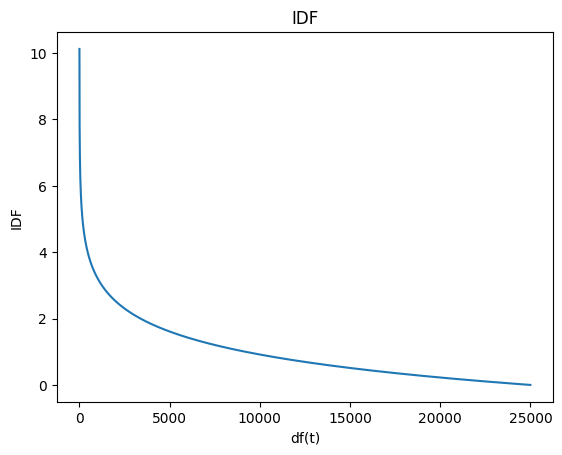

In [18]:
n_samples = 25000
idf = np.log(n_samples/np.arange(1,n_samples))
plt.title("IDF")
plt.xlabel("df(t)")
plt.ylabel("IDF")
plt.plot(idf)
plt.show()

In [19]:
vectorizer = TfidfVectorizer(stop_words = stop_words, max_features = 5000)
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.fit_transform(x_test)

In [20]:
print(x_train.shape, x_test.shape)

(25000, 5000) (25000, 5000)


## Problem Three: Learning with TF-IDF

In [21]:
lgbm_clf = LGBMClassifier().fit(x_train, y_train)
y_pred = lgbm_clf.predict(x_test)
print(accuracy_score(y_test, y_pred))

[LightGBM] [Info] Number of positive: 12500, number of negative: 12500
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.558478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 445520
[LightGBM] [Info] Number of data points in the train set: 25000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
0.57248


In [22]:
# Training Logistic Regression classifier
logistic_reg = LogisticRegression()
logistic_reg.fit(x_train, y_train)

# Predictions
y_pred = logistic_reg.predict(x_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.5566


In [23]:
# Training SVM classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(x_train, y_train)

# Predictions
y_pred = svm_classifier.predict(x_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.54788


In [24]:
print(confusion_matrix(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

[[7536 4964]
 [6339 6161]]
0.5537977528089888
0.49288


## Problem Four: Scratch mounting of TF-IDF

In [51]:
tf = gram_1.copy()
idf = gram_1.copy()

# Calculate term frequency (tf)
for i in range(len(tf)):
    tf.iloc[i, :] = tf.iloc[i, :] / tf.iloc[i, :].sum()

# Calculate inverse document frequency (idf)
num_docs = len(idf)
for column in idf.columns:
    idf[column] = np.log(num_docs / idf[column].sum())

# If you want to combine tf and idf into tf-idf
tf_idf = tf * idf

In [52]:
tf

,is,soooo,a,funny,what,ever,movie,this,i,never,best
0,0.2,0.2,0.0,0.2,0.0,0.0,0.2,0.2,0.0,0.0,0.0
1,0.0,0.0,0.2,0.0,0.2,0.0,0.2,0.0,0.2,0.2,0.0
2,0.0,0.0,0.0,0.0,0.0,0.2,0.4,0.2,0.0,0.0,0.2


In [53]:
idf

,is,soooo,a,funny,what,ever,movie,this,i,never,best
0,1.098612,1.098612,1.098612,1.098612,1.098612,1.098612,-0.287682,0.405465,1.098612,1.098612,1.098612
1,1.098612,1.098612,1.098612,1.098612,1.098612,1.098612,-0.287682,0.405465,1.098612,1.098612,1.098612
2,1.098612,1.098612,1.098612,1.098612,1.098612,1.098612,-0.287682,0.405465,1.098612,1.098612,1.098612


In [54]:
tf*idf

,is,soooo,a,funny,what,ever,movie,this,i,never,best
0,0.219722,0.219722,0.000000,0.219722,0.000000,0.000000,-0.057536,0.081093,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.219722,0.000000,0.219722,0.000000,-0.057536,0.000000,0.219722,0.219722,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.219722,-0.115073,0.081093,0.000000,0.000000,0.219722


**Word2Vec**

In [29]:
!pip install gensim

In [30]:
from gensim.models import Word2Vec
sentences = [['this', 'movie', 'is', 'very', 'good'], ['this', 'film', 'is', 'a', 'good'], ['very', 'bad', 'very', 'very', 'bad']]
model = Word2Vec(sentences,min_count=1, vector_size=15)

print("Vocabulary List : {}".format(model.wv.index_to_key))

for vocab in model.wv.index_to_key:
  print("{} vector: \n{}".format(vocab, model.wv[vocab]))

Vocabulary List : ['very', 'bad', 'good', 'is', 'this', 'a', 'film', 'movie']
very vector: 
[-0.00357485  0.00157621  0.03402233  0.06006182 -0.06201966 -0.04744539
  0.04305915  0.05981992 -0.03343619 -0.02508914  0.04920336 -0.01022314
 -0.03024409  0.04369368 -0.03240107]
bad vector: 
[-0.01210678  0.0191772   0.00661249 -0.05523477 -0.06299212  0.04874511
  0.03380175  0.04505129  0.00508577  0.04233927 -0.02270244 -0.00630934
  0.03845716 -0.05014425 -0.02624069]
good vector: 
[-0.05007721 -0.00620028  0.06358746 -0.04879444 -0.01555846 -0.01291827
  0.05384958 -0.0395393   0.00030108 -0.03169156 -0.06402367  0.03338195
 -0.05839724 -0.02927884 -0.000234  ]
is vector: 
[-0.00197456 -0.05107525  0.06409869  0.03321393  0.06155467 -0.05438646
  0.02997218 -0.02758068  0.00549694  0.05665782 -0.02974803  0.03011686
 -0.04524669 -0.02365674  0.06265712]
this vector: 
[-0.01051768  0.00214248 -0.0276042  -0.05121792 -0.01005339  0.0164653
 -0.00592018  0.03689108 -0.01828652  0.0150671

In [55]:
model.wv.most_similar(positive='good', topn=3)

[('is', 0.37519174814224243),
 ('a', 0.23854228854179382),
 ('bad', 0.14096243679523468)]

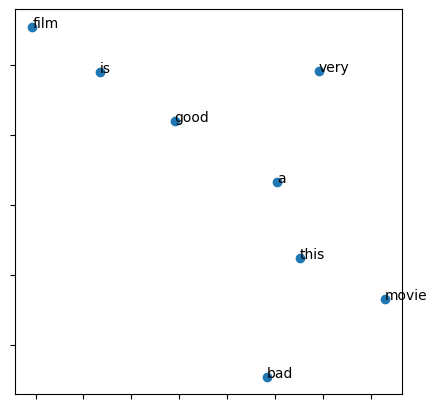

['very', 'bad', 'good', 'is', 'this', 'a', 'film', 'movie']

In [69]:
vocabs = model.wv.index_to_key

tsne_model = TSNE(perplexity=1, n_components=2, init="pca", n_iter=5000, random_state=23)
vectors_tsne = tsne_model.fit_transform(model.wv[vocabs])

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1])
for i, word in enumerate(list(vocabs)):
    plt.annotate(word, xy=(vectors_tsne[i, 0], vectors_tsne[i, 1]))
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()
vocabs

## Problem Five: Pre-processing of corpus

In [79]:
# Load the training data
x_train = train_review.data

def preprocess_text(text):
    # Remove URLs with regular expression
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters with regular expression
    text = re.sub(r'\W', ' ', text)

    # Convert to lowercase
    text = text.lower()

    # Split into words (tokens)
    words = text.split()

    return words

# Apply preprocessing to each review in the training data
x_train_preprocessed = [preprocess_text(review) for review in x_train]

# Print some examples to verify
for i in range(3):
    print(f"Original: {x_train[i][:100]}")
    print(f"Preprocessed: {x_train_preprocessed[i][:10]}")
    print()

Original: Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mu
Preprocessed: ['zero', 'day', 'leads', 'you', 'to', 'think', 'even', 're', 'think', 'why']

Original: Words can't describe how bad this movie is. I can't explain it by writing only. You have too see it 
Preprocessed: ['words', 'can', 't', 'describe', 'how', 'bad', 'this', 'movie', 'is', 'i']

Original: Everyone plays their part pretty well in this "little nice movie". Belushi gets the chance to live p
Preprocessed: ['everyone', 'plays', 'their', 'part', 'pretty', 'well', 'in', 'this', 'little', 'nice']



## Problem Six: Learning Word2Vec

In [82]:
# Initialize Word2Vec model
model_2 = Word2Vec(min_count=1, vector_size=10, window=5, sg=1)

# Build vocabulary from training data
model_2.build_vocab(x_train_preprocessed)

# Train Word2Vec model
model_2.train(x_train_preprocessed, total_examples=model_2.corpus_count, epochs=model_2.epochs)

vocabs = model_2.wv.index_to_key
print(vocabs)

['the', 'and', 'a', 'of', 'to', 'is', 'br', 'it', 'in', 'i', 'this', 'that', 's', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', 't', 'you', 'on', 'not', 'he', 'are', 'his', 'have', 'be', 'one', 'all', 'at', 'they', 'by', 'an', 'who', 'so', 'from', 'like', 'there', 'her', 'or', 'just', 'about', 'out', 'if', 'has', 'what', 'some', 'good', 'can', 'more', 'she', 'when', 'very', 'up', 'time', 'no', 'even', 'my', 'would', 'which', 'story', 'only', 'really', 'see', 'their', 'had', 'we', 'were', 'me', 'well', 'than', 'much', 'get', 'bad', 'been', 'people', 'will', 'do', 'other', 'also', 'into', 'first', 'great', 'because', 'how', 'him', 'don', 'most', 'made', 'its', 'then', 'way', 'make', 'them', 'could', 'too', 'movies', 'any', 'after', 'think', 'characters', 'character', 'watch', 'two', 'films', 'seen', 'many', 'life', 'being', 'plot', 'acting', 'never', 'love', 'little', 'best', 'where', 'over', 'did', 'show', 'know', 'off', 'ever', 'man', 'does', 'here', 'better', 'your', 'end', 'sti

## Problem Seven: (Advance assignment) Vector Visualization

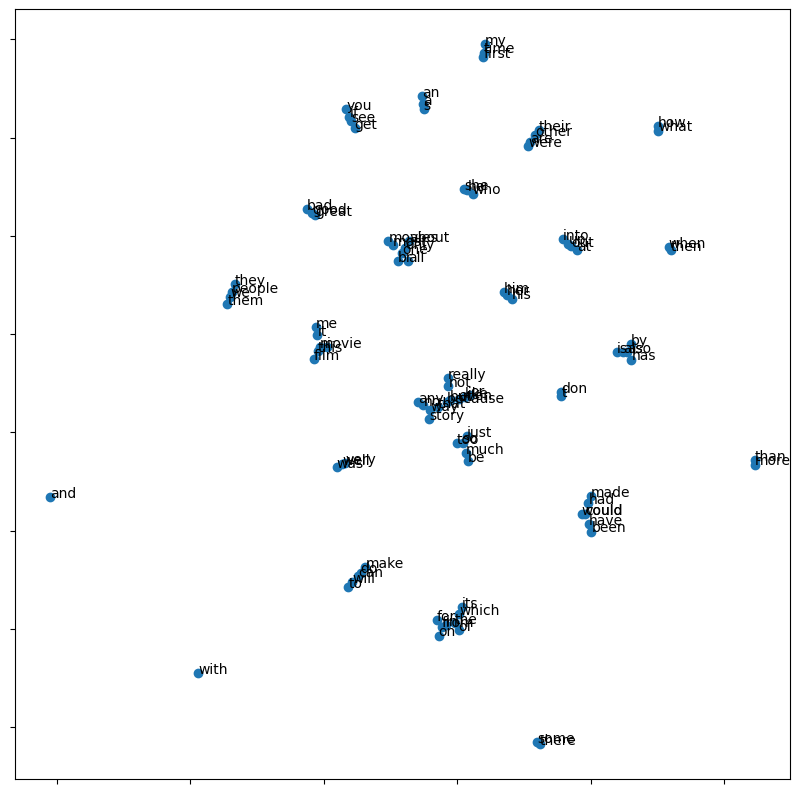

In [83]:
# Select a subset of the vocabulary for faster performance
subset_size = 100
subset_vocabs = model_2.wv.index_to_key[:subset_size]
subset_vectors = model_2.wv[subset_vocabs]

# Initialize and fit the t-SNE model on the subset of vectors
tsne_model = TSNE(perplexity=1, n_components=2, init="pca", n_iter=5000, random_state=23)
vectors_tsne = tsne_model.fit_transform(subset_vectors)

# Visualize the subset of vectors
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1])

for i, word in enumerate(subset_vocabs):
    ax.annotate(word, xy=(vectors_tsne[i, 0], vectors_tsne[i, 1]))

ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()

In [89]:
model_2.wv.most_similar(positive='people', topn=5)

[('we', 0.9807459712028503),
 ('morons', 0.9807147979736328),
 ('romania', 0.9710312485694885),
 ('themselves', 0.9691008925437927),
 ('they', 0.9686741828918457)]